# Regression on the Titanic dataset

- [Link to dataset](https://www.kaggle.com/c/titanic/data)

In [1]:
path= "./data/"
csv_train= "train.csv"
csv_test= "test.csv"
import pandas as pd 
train= pd.read_csv(path+csv_train)
test= pd.read_csv(path+csv_test)
data= train.copy()

## EDA

In [2]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [3]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
data.shape

(891, 12)

In [5]:
data[data.Survived==1].Cabin.value_counts()

B96 B98    4
E101       3
F33        3
B28        2
D36        2
          ..
C85        1
C123       1
B39        1
B101       1
C70        1
Name: Cabin, Length: 101, dtype: int64

In [6]:
data[data.Embarked.isna()].Survived

61     1
829    1
Name: Survived, dtype: int64

In [7]:
data.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [8]:
data[data.Embarked=="S"].Survived.value_counts()

0    427
1    217
Name: Survived, dtype: int64

In [9]:
data.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
50.4958     1
13.8583     1
8.4583      1
7.7250      1
7.5208      1
Name: Fare, Length: 248, dtype: int64

In [10]:
data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [11]:
data.groupby("Pclass")[["Survived"]].agg({"Survived": "sum"})

,Survived
Pclass,
1,136
2,87
3,119


In [12]:
df= pd.pivot_table(data=data,index="Pclass",values="Survived",columns="Sex")
df

Sex,female,male
Pclass,,
1,0.968085,0.368852
2,0.921053,0.157407
3,0.500000,0.135447


In [13]:
data["Sex_bin"]= pd.factorize(data.Sex)[0]
# data.Sex_bin

In [14]:
# correlation
corr_mat= data[["Age","Sex_bin","Pclass","Survived"]].corr()
corr_mat

,Age,Sex_bin,Pclass,Survived
Age,1.000000,-0.093254,-0.369226,-0.077221
Sex_bin,-0.093254,1.000000,-0.131900,0.543351
Pclass,-0.369226,-0.131900,1.000000,-0.338481
Survived,-0.077221,0.543351,-0.338481,1.000000


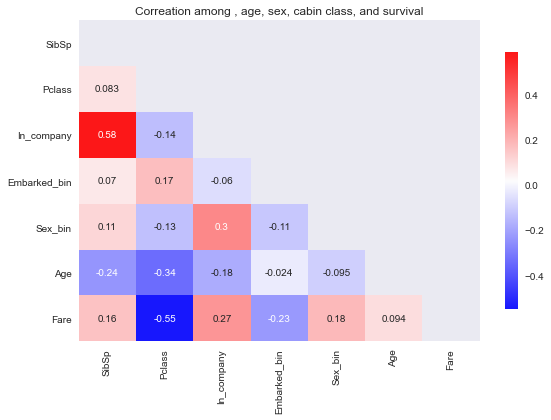

In [58]:
import numpy as np 
mask= np.triu(np.ones_like(corr_mat,dtype=bool))

import matplotlib.pyplot as plt 
import seaborn as sns 
plt.style.use("seaborn") # seaborn-poster
# sns.set_theme(palette="bright",style="darkgrid")
sns.heatmap(corr_mat,annot=True,mask=mask,cmap=sns.color_palette("bwr", as_cmap=True),alpha=.9,cbar_kws={"shrink":.8})
plt.title("Correation among , age, sex, cabin class, and survival")
# from matplotlib import rcParams rcParams["axes.titlepad"]= 20
plt.show()

<img src="./img/01_heatmap_age_sex_pclass_survived.png" width="450" alt="https://raw.githubusercontent.com/da2021-jieun/datasci_exercises/main/regression/img/01_heatmap_age_sex_pclass_survived1.png">

## Preprocessing
- Fill in empty cells of `Age`, `Embarked`

- Drop non-useful columns: `Ticket`, `Cabin`, `Name`

In [16]:
data.groupby("Sex")["Age"].mean(), data.groupby("Sex")["Age"].median()

(Sex
 female    27.915709
 male      30.726645
 Name: Age, dtype: float64,
 Sex
 female    27.0
 male      29.0
 Name: Age, dtype: float64)

In [17]:
data.Age.median(), data.Age.mean()

(28.0, 29.69911764705882)

In [18]:
# - Fill in empty cells of `Age`
# transform()
# https://stackoverflow.com/questions/40957932/transform-vs-aggregate-in-pandas
data.Age.fillna(data.groupby("Sex")["Age"].transform("median"),inplace=True)

In [19]:
# - Fill in empty cells of `Embarked` with the last value before NaN
data.Embarked.fillna(method="pad",inplace=True)

In [20]:
# Drop non-useful columns: `Ticket`, `Cabin`
data.drop(["Ticket","Cabin","Name","Sex"],axis=1,inplace=True)

## Feature Engineering
- Add features: `Age_bin`, `Fare_bin`, `Solo`

In [21]:
data.Age.max()

80.0

In [22]:
data["Age_group"]= pd.cut(data.Age,bins=[0,9,16,30,55,80]) #
df_agegroup= data[["Age_group","Survived","Age"]].groupby("Age_group").agg(dict(Age=["min","max","median","mean","std"], Age_group=["count"]))

In [23]:
print(df_agegroup)

             Age                                   Age_group
             min   max median       mean       std     count
Age_group                                                   
(0, 9]      0.42   9.0    4.0   4.083387  2.834747        62
(9, 16]    10.00  16.0   15.0  14.407895  1.951629        38
(16, 30]   17.00  30.0   27.0  25.387860  3.939789       486
(30, 55]   30.50  55.0   39.0  39.996226  6.789725       265
(55, 80]   55.50  80.0   61.0  62.350000  5.619563        40


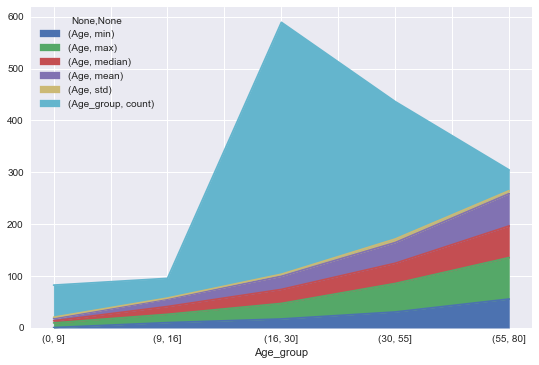

In [59]:
df_agegroup.plot(kind="area")#,x="Age_group",y="Age"
plt.style.use("Solarize_Light2") 

plt.show()

<img src="./img/02_groupby_agegroup_stats_plot_area.png" width="600">

In [25]:
data.Age_group.value_counts()

(16, 30]    486
(30, 55]    265
(0, 9]       62
(55, 80]     40
(9, 16]      38
Name: Age_group, dtype: int64

In [26]:
df_age= data.groupby("Age_group")["Age"].agg(["min","max","median","mean","std","size"])
print(df_age)

             min   max  median       mean       std  size
Age_group                                                
(0, 9]      0.42   9.0     4.0   4.083387  2.834747    62
(9, 16]    10.00  16.0    15.0  14.407895  1.951629    38
(16, 30]   17.00  30.0    27.0  25.387860  3.939789   486
(30, 55]   30.50  55.0    39.0  39.996226  6.789725   265
(55, 80]   55.50  80.0    61.0  62.350000  5.619563    40


In [27]:
data["Age_bin"]= pd.Categorical(data.Age_group).codes
data.head(1)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,Embarked,Sex_bin,Age_group,Age_bin
0,1,0,3,22.0,1,0,7.25,S,0,"(16, 30]",2


In [28]:
data[["Age_group","Age_bin"]].value_counts()

Age_group  Age_bin
(16, 30]   2          486
(30, 55]   3          265
(0, 9]     0           62
(55, 80]   4           40
(9, 16]    1           38
dtype: int64

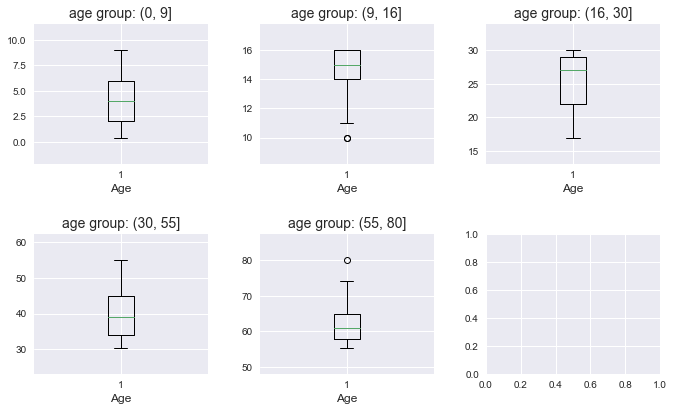

In [61]:
plt.style.use("seaborn")
# data.groupby("Age_bin")[["Age"]].plot(kind="box",subplots=True,grid=True,sharex=True,sharey=False,title="Boxplot for Each Age Group")
grouped= data.groupby("Age_group")[["Age"]]
ncols= int(grouped.ngroups/2)+(grouped.ngroups%2) #round up
fig,ax= plt.subplots(figsize=(10,6),nrows=2,ncols=ncols,gridspec_kw=dict(hspace=.5,wspace=0.3))
groups= zip(grouped.groups.keys(),ax.flatten())
for i,(key,axis) in enumerate(groups):
    axis.boxplot(grouped.get_group(key))
    axis.set_xlabel("Age",fontsize=12)
    axis.set_title("age group: %s"%str(key),fontsize=14)
    axis.margins(x=.1,y=.3)

plt.show()

<img src="./img/03_groupby_age_group_boxplot.png" width="600" alt="https://raw.githubusercontent.com/da2021-jieun/datasci_exercises/main/regression/img/02_groupby_agegroup_stats_plot_area.png">

In [30]:
data.insert(7,"Embarked_bin",pd.Categorical(data.Embarked).codes)

In [31]:
data["Fare_group"]= pd.cut(data.Fare,bins=[0,8,15,31,513])
data.insert(6,"Fare_bin",pd.Categorical(data.Fare_group).codes)

In [32]:
data.insert(4,"In_company",((data.SibSp+data.Parch)>0).astype(int))

In [33]:
data.head(3)

,PassengerId,Survived,Pclass,Age,In_company,SibSp,Parch,Fare_bin,Fare,Embarked_bin,Embarked,Sex_bin,Age_group,Age_bin,Fare_group
0,1,0,3,22.0,1,1,0,0,7.2500,2,S,0,"(16, 30]",2,"(0, 8]"
1,2,1,1,38.0,1,1,0,3,71.2833,0,C,1,"(30, 55]",3,"(31, 513]"
2,3,1,3,26.0,0,0,0,0,7.9250,2,S,1,"(16, 30]",2,"(0, 8]"


In [34]:
data.Pclass.value_counts()/data.shape[0]

3    0.551066
1    0.242424
2    0.206510
Name: Pclass, dtype: float64

In [35]:
data.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Age', 'In_company', 'SibSp',
       'Parch', 'Fare_bin', 'Fare', 'Embarked_bin', 'Embarked', 'Sex_bin',
       'Age_group', 'Age_bin', 'Fare_group'],
      dtype='object')

In [36]:
# data.dtypes

In [37]:
cols= ['Pclass', 'In_company','Embarked_bin', 'Fare_bin', 'Sex_bin','Age_bin',"Fare","SibSp","Age"]
X= data[cols].values
y= data.Survived.values

import statsmodels.api as sm 
X= sm.add_constant(X)

model_ols= sm.OLS(y,X)
res= model_ols.fit()
print(res.summary(xname=["Intercept"]+cols,yname="Survived"))

                            OLS Regression Results                            
Dep. Variable:               Survived   R-squared:                       0.401
Model:                            OLS   Adj. R-squared:                  0.395
Method:                 Least Squares   F-statistic:                     65.64
Date:                Thu, 08 Jul 2021   Prob (F-statistic):           4.41e-92
Time:                        07:33:16   Log-Likelihood:                -393.35
No. Observations:                 891   AIC:                             806.7
Df Residuals:                     881   BIC:                             854.6
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.7864      0.091      8.609   

In [38]:
R_sqrd= []
from sklearn.model_selection import train_test_split
for i in range(100):
    X_train,X_test,y_train,y_test= train_test_split(X,y,test_size=.3)
    model= sm.OLS(y_train,X_train)
    res= model.fit()
    pred= res.predict(X_test)
    R2= 1 - sum((pred-y_test)**2)/sum((y_test-y_test.mean())**2)
    R_sqrd.append(R2)
print("R_squared",np.mean(R_sqrd))

R_squared 0.37899024511094415


In [39]:
set(cols).difference(set(["Age_bin","Fare_bin"]))

{'Age', 'Embarked_bin', 'Fare', 'In_company', 'Pclass', 'Sex_bin', 'SibSp'}

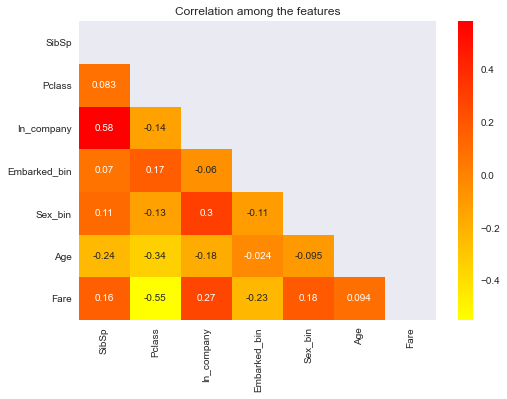

In [40]:
plt.style.use("seaborn")
corr_mat= data[set(cols).difference(set(["Age_bin","Fare_bin"]))].corr()
mask= np.triu(np.ones_like(corr_mat,dtype=bool))
sns.heatmap(corr_mat,mask=mask,cbar=True,annot=True,cmap="autumn_r")
plt.title("Correlation among the features")
plt.show()

<img src="./img/04_corr_mat_ols_features.png" width="600" alt="https://raw.githubusercontent.com/da2021-jieun/datasci_exercises/main/regression/img/04_corr_mat_ols_features.png">

## Next Step: Look at outliers in the data